# import package

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn.dense import dense_diff_pool
from torch_geometric.nn import GCNConv, TopKPooling

# build bool function 

## SinCos PE code

In [9]:
def sinusoidal_index_pe(num_nodes, dim):
    # 初始化PE矩阵
    pe = torch.zeros(num_nodes, dim)
    # 生成节点的位置索引，[0, 1, 2, 3, ..., node_num - 1], 类似NLP的句子token
    position = torch.arange(0, num_nodes).unsqueeze(1) # (node_num, 1)
    # 生成不同维度的频率
    div_term = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.0) / dim))
    # 偶数列为sin
    pe[:, 0::2] = torch.sin(position * div_term)
    # 奇数列为cos
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

### test code

In [7]:
num_nodes = 100
dim = 8
pe = sinusoidal_index_pe(num_nodes, dim)
print("PE shape:", pe.shape)
print("PE values:\n", pe[:5])

PE shape: torch.Size([100, 8])
PE values:
 tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
          9.9995e-01,  1.0000e-03,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
          9.9980e-01,  2.0000e-03,  1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  2.9552e-01,  9.5534e-01,  2.9995e-02,
          9.9955e-01,  3.0000e-03,  1.0000e+00],
        [-7.5680e-01, -6.5364e-01,  3.8942e-01,  9.2106e-01,  3.9989e-02,
          9.9920e-01,  4.0000e-03,  9.9999e-01]])


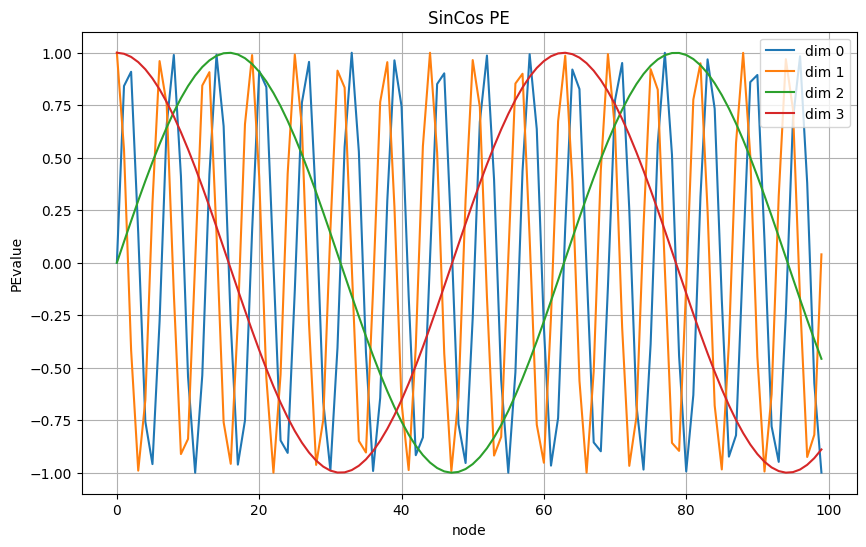

In [8]:
plt.figure(figsize=(10,6))
positions = range(num_nodes)

# 画前4个维度(0,1,2,3)
for i in range(4):
    plt.plot(positions, pe[:,i], label=f"dim {i}")

plt.title("SinCos PE")
plt.xlabel("node")
plt.ylabel("PEvalue")
plt.legend()
plt.grid(True)
plt.show()

## 结果分析
- dim0 和 dim1 是高频线，短节点范围内重复多次
- dim2 和 dim3 是低频线，长节点范围内重复1-2次
- 从高维到低维逐层递减
- 高频用于局部差异，低频用于全局顺序
- 叠加之后每一个位置都唯一且平滑

## Laplacian PE （only test）

In [16]:
def laplacian_pe(adj, k=4):
    # 计算度矩阵
    D = np.diag(np.sum(adj, axis=1))
    # 拉普拉斯矩阵
    L = D - adj
    # 对L矩阵做特征分解
    eigvals, eigvecs = np.linalg.eigh(L)
    # 跳过第一个平凡解
    idx = np.argsort(eigvals)[1:k+1]  
    return torch.tensor(eigvecs[:, idx], dtype=torch.float32)

In [15]:
A = np.array([
    [0,1,0,1],
    [1,0,1,0],
    [0,1,0,1],
    [1,0,1,0]
], dtype=float)

pe, eigvals = laplacian_pe(A, k=2)
print("拉普拉斯特征值:", eigvals)
print("LPE编码:\n", pe)

拉普拉斯特征值: [-8.0838114e-16  2.0000000e+00  2.0000000e+00  4.0000000e+00]
LPE编码:
 tensor([[ 0.0000e+00,  7.0711e-01],
        [-7.0711e-01, -2.1223e-16],
        [ 2.8708e-16, -7.0711e-01],
        [ 7.0711e-01,  7.4848e-17]])


## Get random graph

In [42]:
def random_graph_with_centrality(num_nodes=10, p=0.3):
    G = nx.erdos_renyi_graph(num_nodes, p)
    adj = nx.to_numpy_array(G)
    
    # === 计算中心性特征 ===
    deg_c = np.array(list(nx.degree_centrality(G).values()))
    bet_c = np.array(list(nx.betweenness_centrality(G).values()))
    close_c = np.array(list(nx.closeness_centrality(G).values()))
    
    # [N,3] 节点特征
    x = np.stack([deg_c, bet_c, close_c], axis=1)
    x = torch.tensor(x, dtype=torch.float32)
    
    return G, x, torch.tensor(adj, dtype=torch.float32)

### 可视化随机图

节点特征 shape: torch.Size([10, 3])
示例节点特征:
 tensor([[0.2222, 0.0556, 0.4183],
        [0.3333, 0.2778, 0.5079],
        [0.3333, 0.1389, 0.5079],
        [0.2222, 0.0556, 0.3951],
        [0.1111, 0.0000, 0.3386]])
邻接矩阵:
 tensor([[0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


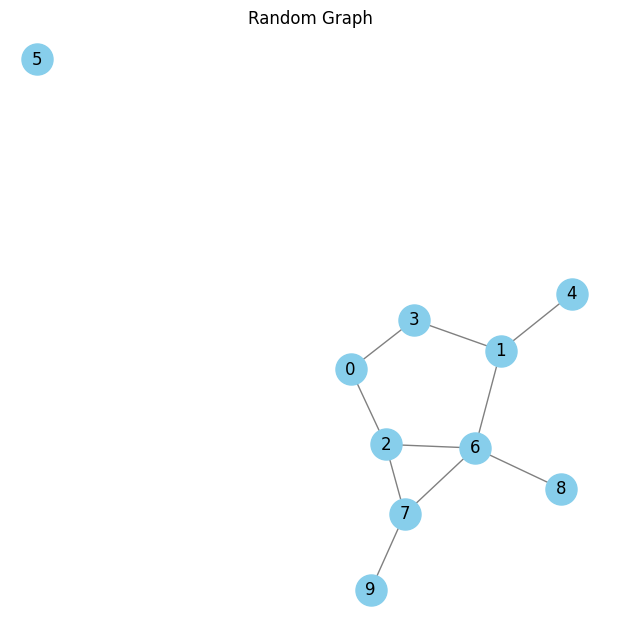

In [47]:
G_nx, x_gt, adj_gt = random_graph_with_centrality(num_nodes=10, p=0.3)
print("节点特征 shape:", x_gt.shape)   # [10,3]
print("示例节点特征:\n", x_gt[:5])
print("邻接矩阵:\n", adj_gt)

# === 画图 ===
plt.figure(figsize=(6,6))
pos = nx.spring_layout(G_nx, seed=42)  # 自动布局
nx.draw(
    G_nx, pos,
    with_labels=True,        # 显示节点编号
    node_color='skyblue',    # 节点颜色
    node_size=500,
    edge_color='gray'
)
plt.title("Random Graph")
plt.show()

## 基础版

In [ ]:
# === 随机图 + 中心性特征 ===
def random_graph_with_centrality(num_nodes=10, p=0.8):
    G = nx.erdos_renyi_graph(num_nodes, p)
    adj = nx.to_numpy_array(G)
    deg_c   = np.array(list(nx.degree_centrality(G).values()))
    bet_c   = np.array(list(nx.betweenness_centrality(G).values()))
    close_c = np.array(list(nx.closeness_centrality(G).values()))
    x = np.stack([deg_c, bet_c, close_c], axis=1)
    x = torch.tensor(x, dtype=torch.float32)
    return G, x, torch.tensor(adj, dtype=torch.float32)

# === SinCos PE ===
def sinusoidal_index_pe(num_nodes, dim):
    pe = torch.zeros(num_nodes, dim)
    position = torch.arange(0, num_nodes).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2) * -(np.log(10000.0) / dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# === Encoder GCN ===
class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, latent_dim):
        super().__init__()
        self.gc1 = GCNConv(in_dim, hidden_dim)
        self.gc_mu = GCNConv(hidden_dim, latent_dim)
        self.gc_logvar = GCNConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index):
        h = F.relu(self.gc1(x, edge_index))
        mu = self.gc_mu(h, edge_index)
        logvar = self.gc_logvar(h, edge_index)
        return mu, logvar

# === TransformerDecoder + Pairwise MLP ===
class TransformerDecoderCross(nn.Module):
    def __init__(self, latent_dim, pe_dim=8, num_heads=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(pe_dim + 3, latent_dim)  # 3=节点中心性特征
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=latent_dim, nhead=num_heads,
            dim_feedforward=latent_dim * 2,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.edge_mlp = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, mask_nodes, sincos_pe, z_enc):
        # mask_nodes=[N,feat], sincos_pe=[N,pe_dim], z_enc=[N,latent_dim]
        q_dec = torch.cat([mask_nodes, sincos_pe], dim=-1)
        q_proj = self.input_proj(q_dec).unsqueeze(0)   # [1,N,latent_dim]
        mem = z_enc.unsqueeze(0)  # encoder memory

        h_dec = self.decoder(q_proj, mem).squeeze(0)  # [N,latent_dim]

        # pairwise edge预测
        N = h_dec.size(0)
        edge_prob = torch.zeros(N, N)
        for i in range(N):
            for j in range(N):
                if i == j:
                    edge_prob[i, j] = 0.0
                else:
                    edge_prob[i, j] = self.edge_mlp(torch.cat([h_dec[i], h_dec[j]], dim=-1))
        return edge_prob

# === GraphVAE with TransformerDecoder ===
class GraphVAETransformer(nn.Module):
    def __init__(self, in_dim, hidden_dim, latent_dim, pe_dim=8):
        super().__init__()
        self.encoder = GCNEncoder(in_dim, hidden_dim, latent_dim)
        self.decoder = TransformerDecoderCross(latent_dim, pe_dim=pe_dim)

    def forward(self, x, edge_index, sincos_pe):
        mu, logvar = self.encoder(x, edge_index)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std  # reparam trick

        mask_nodes = torch.zeros_like(x)  # 初始mask节点=0
        edge_prob = self.decoder(mask_nodes, sincos_pe, z)
        return edge_prob, mu, logvar

# === Loss: BCE + KL ===
def graph_vae_loss(A_pred, A_gt, mu, logvar):
    recon = F.binary_cross_entropy(A_pred.view(-1), A_gt.view(-1))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

# === 可视化 ===
def visualize_gt_vs_pred(adj_gt, edge_pred_bin):
    G_gt = nx.from_numpy_array(adj_gt.numpy())
    G_pred = nx.from_numpy_array(edge_pred_bin.numpy())
    pos = nx.spring_layout(G_gt, seed=42)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    nx.draw(G_gt, pos, with_labels=True, node_color='skyblue', edge_color='green')
    plt.title("Ground Truth")
    plt.subplot(1,2,2)
    nx.draw(G_pred, pos, with_labels=True, node_color='orange', edge_color='red')
    plt.title("Predicted Graph")
    plt.show()

# === 生成图 ===
G_nx, x_gt, adj_gt = random_graph_with_centrality(num_nodes=10, p=0.3)
edge_index = torch.tensor(list(G_nx.edges), dtype=torch.long).t().contiguous()
print("节点特征 shape:", x_gt.shape)

sincos_pe = sinusoidal_index_pe(x_gt.size(0), dim=8)

# === 初始化 GraphVAE+TransformerDecoder ===
model = GraphVAETransformer(in_dim=x_gt.size(1), hidden_dim=32, latent_dim=32, pe_dim=8)
opt = torch.optim.Adam(model.parameters(), lr=0.005)

# === 训练 ===
for step in range(500):
    A_pred, mu, logvar = model(x_gt, edge_index, sincos_pe)
    loss = graph_vae_loss(A_pred, adj_gt, mu, logvar)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if step % 100 == 0:
        print(f"Step {step}, Loss={loss.item():.4f}")

# === 最终预测 ===
A_pred, mu, logvar = model(x_gt, edge_index, sincos_pe)
edge_pred_bin = (A_pred > 0.6).float()

print("\nGT adjacency:\n", adj_gt)
print("\nPred adjacency:\n", edge_pred_bin)

visualize_gt_vs_pred(adj_gt, edge_pred_bin)


节点特征 shape: torch.Size([10, 3])
Step 0, Loss=0.6350


Generated adjacency:
 tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 1.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]])


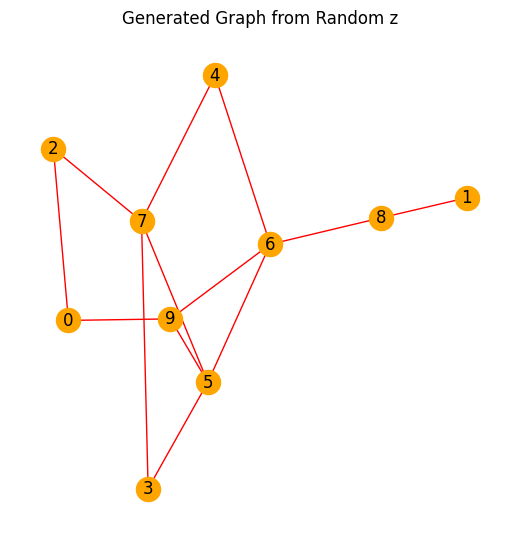

In [80]:
# === 生成新图 ===

def generate_new_graph(model, num_nodes=10, latent_dim=32, pe_dim=8, threshold=0.5):
    # 1. 随机采样 latent z ~ N(0, I)
    z_random = torch.randn(num_nodes, latent_dim)
    
    # 2. 生成 SinCos 位置编码（假设节点索引是 0..N-1）
    sincos_pe = sinusoidal_index_pe(num_nodes, dim=pe_dim)
    
    # 3. 初始 MASK 节点（占位，GraphVAE Decoder 需要这个）
    mask_nodes = torch.zeros((num_nodes, 3))  # 3=中心性特征维度占位
    
    # 4. 用训练好的 Decoder 生成邻接矩阵
    model.eval()
    with torch.no_grad():
        A_gen = model.decoder(mask_nodes, sincos_pe, z_random)
    
    # 5. 阈值化得到 0/1 邻接矩阵
    A_bin = (A_gen > threshold).float()
    
    return A_bin

# === 调用生成 ===
A_generated = generate_new_graph(model, num_nodes=10, latent_dim=32, pe_dim=8, threshold=0.5)

print("Generated adjacency:\n", A_generated)

# === 可视化生成的新图 ===
G_new = nx.from_numpy_array(A_generated.numpy())
plt.figure(figsize=(5,5))
nx.draw(G_new, with_labels=True, node_color='orange', edge_color='red')
plt.title("Generated Graph from Random z")
plt.show()


节点特征 shape: torch.Size([10, 3])
Step 0, Loss=0.7588
Step 100, Loss=0.4102
Step 200, Loss=0.2118
Step 300, Loss=0.1180
Step 400, Loss=0.0670

GT adjacency:
 tensor([[0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 1., 1., 0., 1., 0., 0., 1., 1.],
        [1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 1., 0., 1., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 1., 0., 1., 1., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 0., 1.],
        [0., 1., 1., 1., 1., 0., 1., 1., 1., 0.]])

Pred adjacency:
 tensor([[0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 0., 1., 0., 0., 1., 1.],
        [1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 1., 0., 1., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 1., 0., 1., 1., 1., 0.],
        [1., 0., 0., 1., 

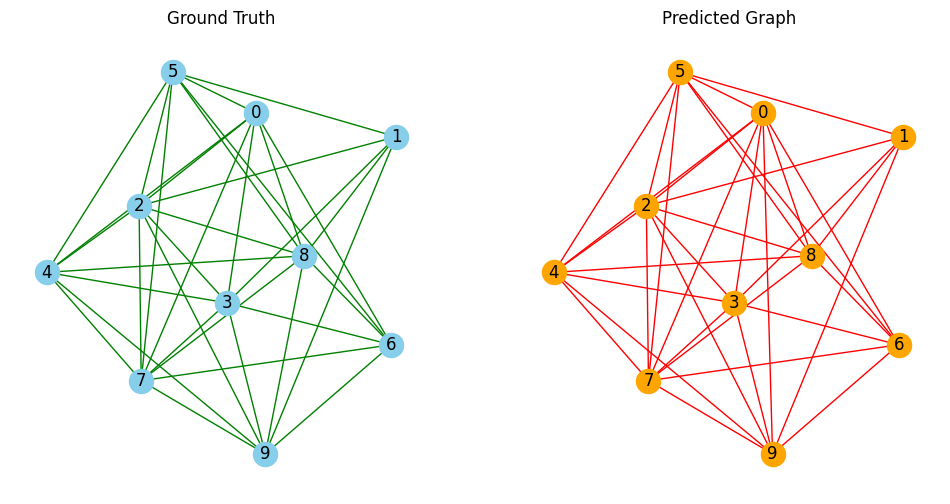

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, TopKPooling

# === 生成随机稀疏图 + 中心性特征 ===
def random_graph_with_centrality(num_nodes=10, p=0.3):
    G = nx.erdos_renyi_graph(num_nodes, p)
    adj = nx.to_numpy_array(G)
    deg_c   = np.array(list(nx.degree_centrality(G).values()))
    bet_c   = np.array(list(nx.betweenness_centrality(G).values()))
    close_c = np.array(list(nx.closeness_centrality(G).values()))
    x = np.stack([deg_c, bet_c, close_c], axis=1)
    x = torch.tensor(x, dtype=torch.float32)
    return G, x, torch.tensor(adj, dtype=torch.float32)

# === SinCos 位置编码 ===
def sinusoidal_index_pe(num_nodes, dim):
    pe = torch.zeros(num_nodes, dim)
    position = torch.arange(0, num_nodes).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2) * -(np.log(10000.0) / dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# === Transformer Decoder + Pairwise MLP (去掉z_global) ===
class TransformerDecoderCross(nn.Module):
    def __init__(self, latent_dim, pe_dim=8, num_heads=4, num_layers=2, feat_dim=3):
        super().__init__()
        self.input_proj = nn.Linear(pe_dim + feat_dim, latent_dim)  # Encoder & Decoder 同样拼接 SinCos+feat
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=latent_dim,
            nhead=num_heads,
            dim_feedforward=latent_dim * 2,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.edge_mlp = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, mask_nodes, sincos_pe, h_pool):
        # === Key/Value: 只用小图骨架 ===
        kv = h_pool.unsqueeze(0)  # [1, N', latent_dim]

        # === Query: MASK节点 + SinCosPE ===
        q_dec = torch.cat([mask_nodes, sincos_pe], dim=-1)  # [N, feat+PE]
        q_proj = self.input_proj(q_dec).unsqueeze(0)        # [1, N, latent_dim]

        # === Transformer Cross-Attn ===
        h_dec = self.decoder(q_proj, kv).squeeze(0)         # [N, latent_dim]

        # === pairwise 边预测 ===
        N = h_dec.size(0)
        edge_prob = torch.zeros(N, N)
        for i in range(N):
            for j in range(N):
                if i == j:
                    edge_prob[i, j] = 0.0
                else:
                    edge_prob[i, j] = self.edge_mlp(torch.cat([h_dec[i], h_dec[j]], dim=-1))
        return edge_prob

# === Encoder: GCN + SinCosPE + TopKPooling ===
class GCNEncoderWithPool(nn.Module):
    def __init__(self, in_dim, pe_dim, hidden_dim, latent_dim, pool_ratio=0.5):
        super().__init__()
        self.gc1 = GCNConv(in_dim + pe_dim, hidden_dim)   # 拼接 SinCosPE
        self.gc_mu = GCNConv(hidden_dim, latent_dim)
        self.gc_logvar = GCNConv(hidden_dim, latent_dim)
        self.pool = TopKPooling(latent_dim, ratio=pool_ratio)

    def forward(self, x_raw, sincos_pe, edge_index):
        # === 拼接 SinCos位置编码 ===
        x_in = torch.cat([x_raw, sincos_pe], dim=-1)      # [N, feat_dim+pe_dim]

        # === GCN提取结构信息 + 索引信息 ===
        h = F.relu(self.gc1(x_in, edge_index))
        mu = self.gc_mu(h, edge_index)
        logvar = self.gc_logvar(h, edge_index)

        # === reparam trick ===
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std  # [N, latent_dim]

        # === TopKPooling 压缩骨架节点 ===
        z_pool, edge_index_pool, _, batch, perm, score = self.pool(z, edge_index, None, batch=None)

        return z_pool, mu, logvar  # 不返回z_global

# === GraphVAE + Pool ===
class GraphVAEPooled(nn.Module):
    def __init__(self, feat_dim, pe_dim, hidden_dim, latent_dim, pool_ratio=0.5):
        super().__init__()
        self.encoder = GCNEncoderWithPool(feat_dim, pe_dim, hidden_dim, latent_dim, pool_ratio)
        self.decoder = TransformerDecoderCross(latent_dim, pe_dim=pe_dim, feat_dim=feat_dim)

    def forward(self, x_raw, edge_index, sincos_pe):
        # === Encoder → 只输出小图骨架节点 ===
        h_pool, mu, logvar = self.encoder(x_raw, sincos_pe, edge_index)

        # === Decoder Query: 原图节点数N的[MASK]+SinCos ===
        mask_nodes = torch.zeros_like(x_raw)  # [N, feat_dim]
        edge_prob = self.decoder(mask_nodes, sincos_pe, h_pool)

        return edge_prob, mu, logvar

# === Loss: BCE + KL ===
def graph_vae_loss(A_pred, A_gt, mu, logvar):
    recon = F.binary_cross_entropy(A_pred.view(-1), A_gt.view(-1))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

# === 可视化 ===
def visualize_gt_vs_pred(adj_gt, edge_pred_bin):
    G_gt = nx.from_numpy_array(adj_gt.numpy())
    G_pred = nx.from_numpy_array(edge_pred_bin.numpy())
    pos = nx.spring_layout(G_gt, seed=42)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    nx.draw(G_gt, pos, with_labels=True, node_color='skyblue', edge_color='green')
    plt.title("Ground Truth")
    plt.subplot(1,2,2)
    nx.draw(G_pred, pos, with_labels=True, node_color='orange', edge_color='red')
    plt.title("Predicted Graph")
    plt.show()

# === 生成测试图 ===
G_nx, x_gt, adj_gt = random_graph_with_centrality(num_nodes=10, p=0.8)
edge_index = torch.tensor(list(G_nx.edges), dtype=torch.long).t().contiguous()
print("节点特征 shape:", x_gt.shape)

pe_dim = 8
sincos_pe = sinusoidal_index_pe(x_gt.size(0), dim=pe_dim)

# === 初始化 GraphVAE+Pool ===
model = GraphVAEPooled(
    feat_dim=x_gt.size(1),   # 3维中心性
    pe_dim=pe_dim, 
    hidden_dim=32, 
    latent_dim=32, 
    pool_ratio=0.5
)
opt = torch.optim.Adam(model.parameters(), lr=0.005)

# === 训练 ===
for step in range(500):
    A_pred, mu, logvar = model(x_gt, edge_index, sincos_pe)
    loss = graph_vae_loss(A_pred, adj_gt, mu, logvar)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if step % 100 == 0:
        print(f"Step {step}, Loss={loss.item():.4f}")

# === 最终预测 ===
A_pred, mu, logvar = model(x_gt, edge_index, sincos_pe)
edge_pred_bin = (A_pred > 0.5).float()

print("\nGT adjacency:\n", adj_gt)
print("\nPred adjacency:\n", edge_pred_bin)
visualize_gt_vs_pred(adj_gt, edge_pred_bin)


## QM9 数据集

In [5]:
from torch_geometric.datasets import QM9
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected

In [6]:
dataset = QM9(root='./qm9')

# 获取一个分子图
data = dataset[0]

# edge_index 可能是单向的，转为无向图
data.edge_index = to_undirected(data.edge_index)

print(data)

Extracting qm9\raw\qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])


## data analyze

In [7]:
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

- x=[5, 11]: [num_nodes, 11]节点特征，原子类型的 one-hot 编码 + 附加特征
- 前4维的特征，0-4 one-hot编码（HCNOF）, 5-10 连通性、价电子、环信息等辅助特征

In [9]:
x_atomic = data.x[:, :5]
x_atomic

tensor([[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])

- edge_index=[2, 8] : 八条边， sorce， des

In [12]:
data.edge_index

tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]])

- edge_attr=[8, 4]：边的属性特征  化学键类型的 one-hot 向量（单/双/三/芳香）

In [15]:
data.edge_attr

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

- y=[1, 19]：属性向量 ，每个属性表示一个化学性质，比如偶极矩，各向同性极化率， 不同类型的能量、频率、热容等分子特征

In [18]:
data.y

tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])

- pos=[5, 3]: 每个原子的空间三维坐标

In [19]:
data.pos

tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
        [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
        [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
        [-5.4080e-01,  1.4475e+00, -8.7660e-01],
        [-5.2380e-01,  1.4379e+00,  9.0640e-01]])

- z=[5]:  原子的原子序号 1: H, 6: C, 7: N, O: 8, F: 9

In [21]:
data.z

tensor([6, 1, 1, 1, 1])

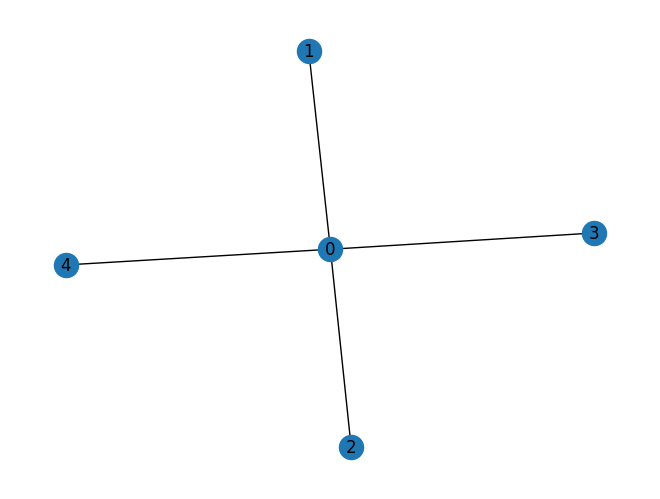

In [22]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

G = to_networkx(data, to_undirected=True)
nx.draw(G, with_labels=True)
plt.show()
